In [ ]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tfimport numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf

# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/SHREC/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)


    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])

    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=28,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)

    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)

    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_fine,C.filters)

2022-11-11 19:59:30.226360: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-11 19:59:30.320245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-11 19:59:30.323450: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-11-11 19:59:30.409697: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-11 19:59:30.445895: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-11-11 19:59:30.454160: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1740160     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

In [8]:
#DD_Net.load_weights('weights/fine_heavy.h5')

## load data

In [13]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [14]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])#[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.54it/s]


In [15]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])#[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 840/840 [00:07<00:00, 119.38it/s]


In [16]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=700,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/700


2022-11-11 20:01:48.161382: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-11 20:01:48.779625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


1960/1960 [==============================] - 9s 5ms/step - loss: 4.0509 - accuracy: 0.0362 - val_loss: 3.3319 - val_accuracy: 0.0500
Epoch 2/700
1960/1960 [==============================] - 0s 155us/step - loss: 3.6407 - accuracy: 0.0658 - val_loss: 3.3323 - val_accuracy: 0.0310
Epoch 3/700
1960/1960 [==============================] - 0s 160us/step - loss: 3.4545 - accuracy: 0.0811 - val_loss: 3.3328 - val_accuracy: 0.0310
Epoch 4/700
1960/1960 [==============================] - 0s 145us/step - loss: 3.2666 - accuracy: 0.1020 - val_loss: 3.3334 - val_accuracy: 0.0440
Epoch 5/700
1960/1960 [==============================] - 0s 140us/step - loss: 3.1213 - accuracy: 0.1388 - val_loss: 3.3342 - val_accuracy: 0.0500
Epoch 6/700
1960/1960 [==============================] - 0s 135us/step - loss: 2.9734 - accuracy: 0.1694 - val_loss: 3.3350 - val_accuracy: 0.0405
Epoch 7/700
1960/1960 [==============================] - 0s 147us/step - loss: 2.8609 - accuracy: 0.1872 - val_loss: 3.3357 - val_ac

Epoch 57/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.4677 - accuracy: 0.9061 - val_loss: 3.7208 - val_accuracy: 0.0345
Epoch 58/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.4610 - accuracy: 0.9041 - val_loss: 3.7691 - val_accuracy: 0.0345
Epoch 59/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.4398 - accuracy: 0.9173 - val_loss: 3.8155 - val_accuracy: 0.0357
Epoch 60/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.4421 - accuracy: 0.9173 - val_loss: 3.8414 - val_accuracy: 0.0393
Epoch 61/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.4383 - accuracy: 0.9148 - val_loss: 3.8504 - val_accuracy: 0.0393
Epoch 62/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.4063 - accuracy: 0.9235 - val_loss: 3.8561 - val_accuracy: 0.0393
Epoch 63/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.3988 - accuracy: 0.9255 - val_

Epoch 113/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.1286 - accuracy: 0.9847 - val_loss: 4.6780 - val_accuracy: 0.0524
Epoch 114/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.1305 - accuracy: 0.9806 - val_loss: 4.6956 - val_accuracy: 0.0548
Epoch 115/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.1300 - accuracy: 0.9867 - val_loss: 4.7226 - val_accuracy: 0.0571
Epoch 116/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.1258 - accuracy: 0.9867 - val_loss: 4.7001 - val_accuracy: 0.0571
Epoch 117/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.1164 - accuracy: 0.9867 - val_loss: 4.6659 - val_accuracy: 0.0571
Epoch 118/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.1216 - accuracy: 0.9862 - val_loss: 4.6214 - val_accuracy: 0.0595
Epoch 119/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.1260 - accuracy: 0.9837

Epoch 168/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0748 - accuracy: 0.9934 - val_loss: 5.2520 - val_accuracy: 0.0583
Epoch 169/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0656 - accuracy: 0.9954 - val_loss: 5.2484 - val_accuracy: 0.0583
Epoch 170/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0774 - accuracy: 0.9913 - val_loss: 5.2476 - val_accuracy: 0.0595
Epoch 171/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0719 - accuracy: 0.9954 - val_loss: 5.2488 - val_accuracy: 0.0595
Epoch 172/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0713 - accuracy: 0.9949 - val_loss: 5.2446 - val_accuracy: 0.0595
Epoch 173/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0832 - accuracy: 0.9908 - val_loss: 5.2417 - val_accuracy: 0.0595
Epoch 174/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0703 - accuracy: 0.9923

Epoch 223/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0700 - accuracy: 0.9969 - val_loss: 5.2633 - val_accuracy: 0.0619
Epoch 224/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0728 - accuracy: 0.9929 - val_loss: 5.2603 - val_accuracy: 0.0619
Epoch 225/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0742 - accuracy: 0.9918 - val_loss: 5.2567 - val_accuracy: 0.0619
Epoch 226/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.0708 - accuracy: 0.9944 - val_loss: 5.2541 - val_accuracy: 0.0619
Epoch 227/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0747 - accuracy: 0.9929 - val_loss: 5.2505 - val_accuracy: 0.0619
Epoch 228/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0719 - accuracy: 0.9913 - val_loss: 5.2476 - val_accuracy: 0.0619
Epoch 229/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0752 - accuracy: 0.9929

Epoch 278/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0721 - accuracy: 0.9959 - val_loss: 4.7873 - val_accuracy: 0.0940
Epoch 279/700
1960/1960 [==============================] - 0s 147us/step - loss: 0.0686 - accuracy: 0.9949 - val_loss: 4.7727 - val_accuracy: 0.0988
Epoch 280/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0693 - accuracy: 0.9934 - val_loss: 4.7585 - val_accuracy: 0.1012
Epoch 281/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0716 - accuracy: 0.9913 - val_loss: 4.7436 - val_accuracy: 0.1024
Epoch 282/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0742 - accuracy: 0.9939 - val_loss: 4.7278 - val_accuracy: 0.1024
Epoch 283/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0747 - accuracy: 0.9908 - val_loss: 4.7126 - val_accuracy: 0.1024
Epoch 284/700
1960/1960 [==============================] - 0s 142us/step - loss: 0.0627 - accuracy: 0.9939

Epoch 333/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0659 - accuracy: 0.9949 - val_loss: 3.8267 - val_accuracy: 0.2202
Epoch 334/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0701 - accuracy: 0.9929 - val_loss: 3.8070 - val_accuracy: 0.2214
Epoch 335/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0723 - accuracy: 0.9949 - val_loss: 3.7865 - val_accuracy: 0.2262
Epoch 336/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0804 - accuracy: 0.9923 - val_loss: 3.7664 - val_accuracy: 0.2274
Epoch 337/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0749 - accuracy: 0.9944 - val_loss: 3.7464 - val_accuracy: 0.2310
Epoch 338/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0726 - accuracy: 0.9913 - val_loss: 3.7253 - val_accuracy: 0.2345
Epoch 339/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0655 - accuracy: 0.9944

Epoch 388/700
1960/1960 [==============================] - 0s 145us/step - loss: 0.0754 - accuracy: 0.9903 - val_loss: 2.6659 - val_accuracy: 0.4214
Epoch 389/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0722 - accuracy: 0.9903 - val_loss: 2.6459 - val_accuracy: 0.4226
Epoch 390/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0679 - accuracy: 0.9949 - val_loss: 2.6254 - val_accuracy: 0.4298
Epoch 391/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0725 - accuracy: 0.9944 - val_loss: 2.6041 - val_accuracy: 0.4310
Epoch 392/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0738 - accuracy: 0.9939 - val_loss: 2.5831 - val_accuracy: 0.4369
Epoch 393/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0697 - accuracy: 0.9918 - val_loss: 2.5627 - val_accuracy: 0.4417
Epoch 394/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0698 - accuracy: 0.9959

Epoch 443/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0707 - accuracy: 0.9939 - val_loss: 1.6304 - val_accuracy: 0.6452
Epoch 444/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0745 - accuracy: 0.9908 - val_loss: 1.6145 - val_accuracy: 0.6464
Epoch 445/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0682 - accuracy: 0.9939 - val_loss: 1.5986 - val_accuracy: 0.6464
Epoch 446/700
1960/1960 [==============================] - 0s 142us/step - loss: 0.0709 - accuracy: 0.9949 - val_loss: 1.5834 - val_accuracy: 0.6512
Epoch 447/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0775 - accuracy: 0.9918 - val_loss: 1.5681 - val_accuracy: 0.6524
Epoch 448/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.0745 - accuracy: 0.9929 - val_loss: 1.5534 - val_accuracy: 0.6560
Epoch 449/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0716 - accuracy: 0.9934

Epoch 498/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.0715 - accuracy: 0.9929 - val_loss: 0.9602 - val_accuracy: 0.7774
Epoch 499/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0645 - accuracy: 0.9974 - val_loss: 0.9518 - val_accuracy: 0.7774
Epoch 500/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0643 - accuracy: 0.9944 - val_loss: 0.9438 - val_accuracy: 0.7810
Epoch 501/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0672 - accuracy: 0.9949 - val_loss: 0.9358 - val_accuracy: 0.7810
Epoch 502/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.0648 - accuracy: 0.9974 - val_loss: 0.9282 - val_accuracy: 0.7833
Epoch 503/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0674 - accuracy: 0.9939 - val_loss: 0.9203 - val_accuracy: 0.7857
Epoch 504/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0677 - accuracy: 0.9934

Epoch 553/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0775 - accuracy: 0.9918 - val_loss: 0.6176 - val_accuracy: 0.8583
Epoch 554/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0714 - accuracy: 0.9939 - val_loss: 0.6135 - val_accuracy: 0.8595
Epoch 555/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0736 - accuracy: 0.9923 - val_loss: 0.6096 - val_accuracy: 0.8619
Epoch 556/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0643 - accuracy: 0.9974 - val_loss: 0.6059 - val_accuracy: 0.8619
Epoch 557/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0674 - accuracy: 0.9939 - val_loss: 0.6022 - val_accuracy: 0.8619
Epoch 558/700
1960/1960 [==============================] - 0s 126us/step - loss: 0.0631 - accuracy: 0.9944 - val_loss: 0.5984 - val_accuracy: 0.8643
Epoch 559/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0622 - accuracy: 0.9964

Epoch 608/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0711 - accuracy: 0.9918 - val_loss: 0.4422 - val_accuracy: 0.8929
Epoch 609/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0658 - accuracy: 0.9949 - val_loss: 0.4402 - val_accuracy: 0.8940
Epoch 610/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0698 - accuracy: 0.9908 - val_loss: 0.4384 - val_accuracy: 0.8940
Epoch 611/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0706 - accuracy: 0.9929 - val_loss: 0.4366 - val_accuracy: 0.8940
Epoch 612/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0657 - accuracy: 0.9934 - val_loss: 0.4348 - val_accuracy: 0.8940
Epoch 613/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0732 - accuracy: 0.9913 - val_loss: 0.4329 - val_accuracy: 0.8929
Epoch 614/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0712 - accuracy: 0.9903

Epoch 663/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0659 - accuracy: 0.9944 - val_loss: 0.3711 - val_accuracy: 0.9083
Epoch 664/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0617 - accuracy: 0.9969 - val_loss: 0.3702 - val_accuracy: 0.9083
Epoch 665/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0619 - accuracy: 0.9954 - val_loss: 0.3695 - val_accuracy: 0.9083
Epoch 666/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0626 - accuracy: 0.9944 - val_loss: 0.3687 - val_accuracy: 0.9083
Epoch 667/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0659 - accuracy: 0.9949 - val_loss: 0.3679 - val_accuracy: 0.9071
Epoch 668/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0683 - accuracy: 0.9939 - val_loss: 0.3672 - val_accuracy: 0.9071
Epoch 669/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0653 - accuracy: 0.9964

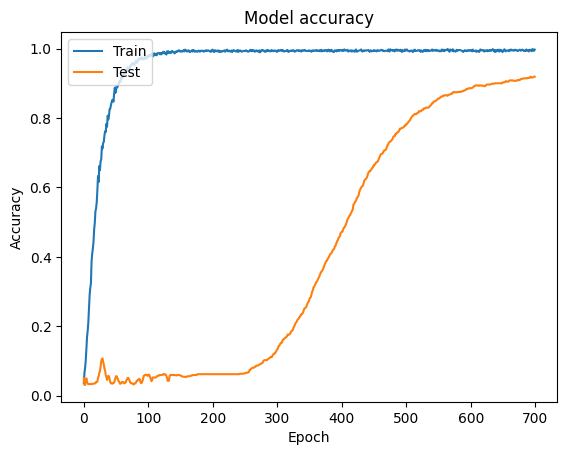

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
DD_Net.save_weights('weights/fine_heavy.h5')

In [19]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [20]:
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

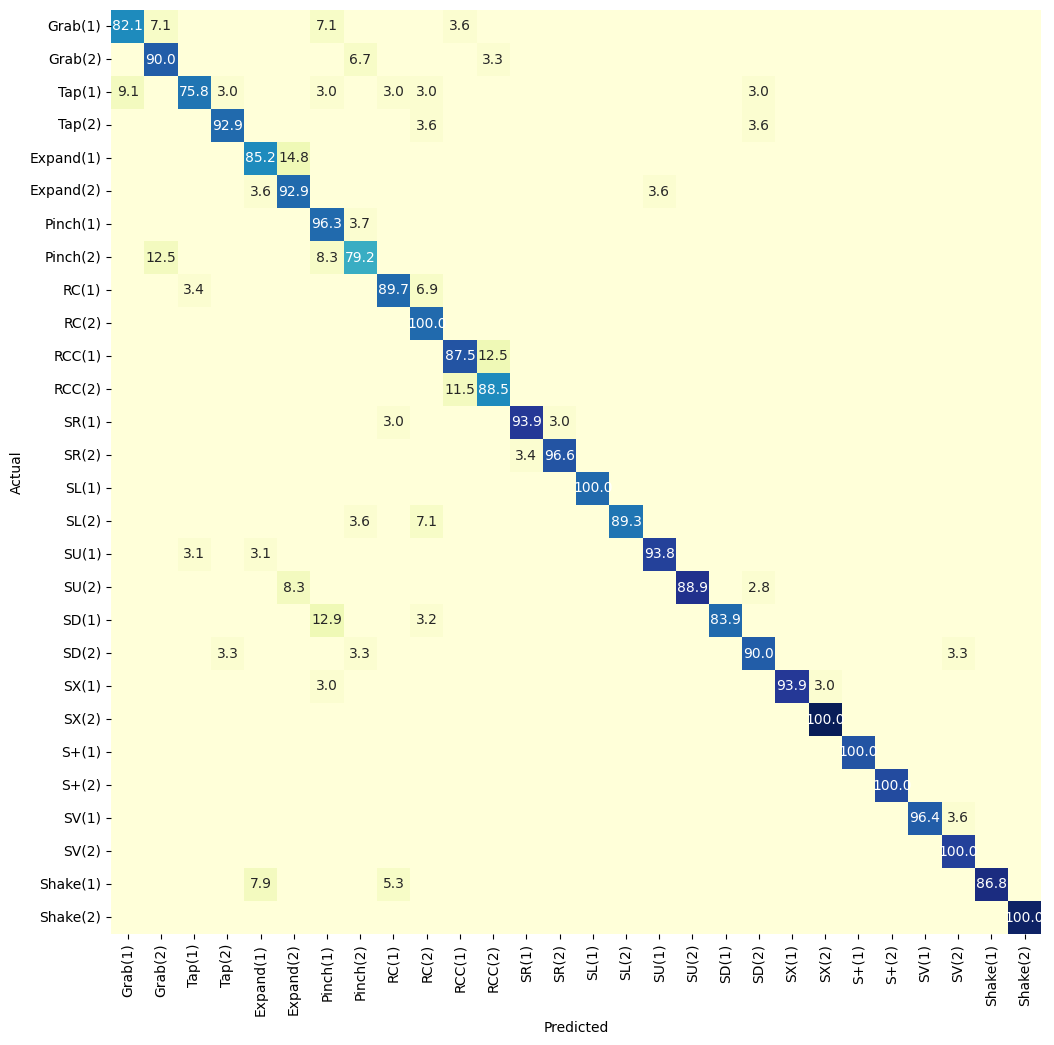

In [21]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_1.png', labels, ymap=None, figsize=(12,12))

## Training with frame_sampling

In [22]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [23]:
epochs = 20 #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_fine)
        label[Train['fine_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
#         print(type(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.94it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0769 - accuracy: 0.9934 - val_loss: 0.3479 - val_accuracy: 0.9190
epoch1


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.78it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 132us/step - loss: 0.0745 - accuracy: 0.9934 - val_loss: 0.3471 - val_accuracy: 0.9202
epoch2


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.24it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 144us/step - loss: 0.0735 - accuracy: 0.9908 - val_loss: 0.3465 - val_accuracy: 0.9214
epoch3


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 116.68it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 130us/step - loss: 0.0742 - accuracy: 0.9934 - val_loss: 0.3459 - val_accuracy: 0.9226
epoch4


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 116.42it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 123us/step - loss: 0.0812 - accuracy: 0.9903 - val_loss: 0.3452 - val_accuracy: 0.9238
epoch5


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.59it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 131us/step - loss: 0.0683 - accuracy: 0.9944 - val_loss: 0.3445 - val_accuracy: 0.9238
epoch6


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 115.72it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 131us/step - loss: 0.0735 - accuracy: 0.9923 - val_loss: 0.3440 - val_accuracy: 0.9250
epoch7


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.93it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 136us/step - loss: 0.0848 - accuracy: 0.9908 - val_loss: 0.3435 - val_accuracy: 0.9250
epoch8


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.20it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 142us/step - loss: 0.0713 - accuracy: 0.9918 - val_loss: 0.3429 - val_accuracy: 0.9250
epoch9


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.74it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 122us/step - loss: 0.0714 - accuracy: 0.9908 - val_loss: 0.3425 - val_accuracy: 0.9250
epoch10


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.17it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 127us/step - loss: 0.0711 - accuracy: 0.9918 - val_loss: 0.3422 - val_accuracy: 0.9250
epoch11


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.27it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 124us/step - loss: 0.0769 - accuracy: 0.9888 - val_loss: 0.3419 - val_accuracy: 0.9262
epoch12


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.69it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 137us/step - loss: 0.0762 - accuracy: 0.9913 - val_loss: 0.3415 - val_accuracy: 0.9262
epoch13


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.71it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 122us/step - loss: 0.0713 - accuracy: 0.9929 - val_loss: 0.3411 - val_accuracy: 0.9262
epoch14


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.49it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 122us/step - loss: 0.0797 - accuracy: 0.9903 - val_loss: 0.3405 - val_accuracy: 0.9250
epoch15


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.33it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 135us/step - loss: 0.0705 - accuracy: 0.9929 - val_loss: 0.3399 - val_accuracy: 0.9250
epoch16


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.34it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 130us/step - loss: 0.0720 - accuracy: 0.9918 - val_loss: 0.3392 - val_accuracy: 0.9262
epoch17


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.62it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 125us/step - loss: 0.0728 - accuracy: 0.9923 - val_loss: 0.3384 - val_accuracy: 0.9262
epoch18


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.02it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 129us/step - loss: 0.0671 - accuracy: 0.9944 - val_loss: 0.3377 - val_accuracy: 0.9262
epoch19


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 115.85it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 125us/step - loss: 0.0662 - accuracy: 0.9964 - val_loss: 0.3370 - val_accuracy: 0.9250


# Plot confusion matrix

In [24]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [25]:
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

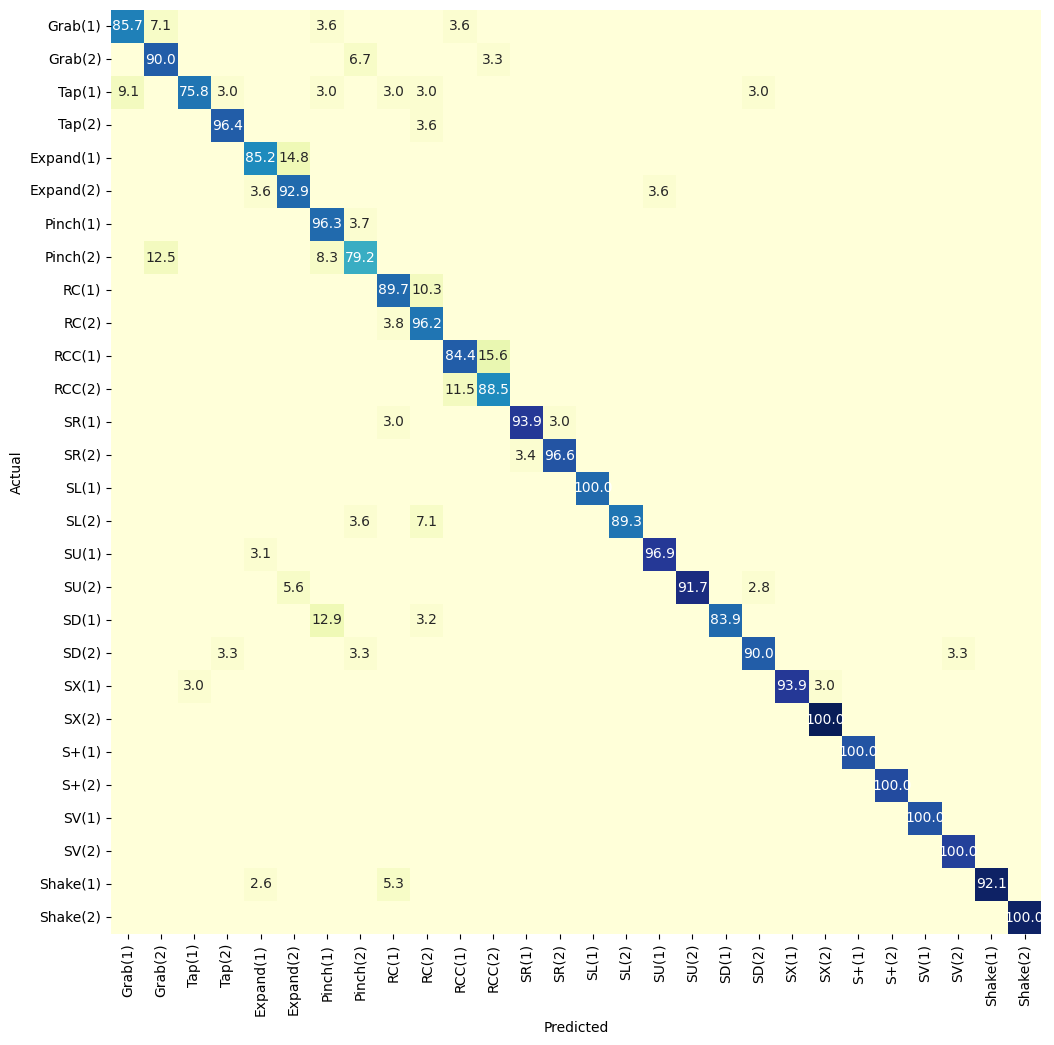

In [26]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_2.png', labels, ymap=None, figsize=(12,12))

# Policy gradient for frame selection  -------train

In [27]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



gamma = 0.7



class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(8448,3))  #20 3960  #10 1980 #30 8448
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):  
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   #Variable进行自动微分；
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r     
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): 
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 25 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = 7*(np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1]))## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 
    n_states=32 
    n_actions=3 
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num = 1
    max_steps = 20  
    all_rewards = []
    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
            Action=[]
            if len(oridata[v])>=32:
                rng = default_rng()
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v]  
            original_fr=XX.clone().detach() 
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 22, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1).reshape([32,22,3])
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

                M = get_CG(q,C)  
                q = q.reshape(1,32,22,3)
                M = M.reshape(1,32,231)

                original_fr = XX
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1   
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob 
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)
        x_tr = torch.stack(x_tr)
        print(x_tr)   
        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
Train = pickle.load(open(C.data_dir+"train.pkl","rb"))


oridata = []


for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,22,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    

labels = [int(Train['fine_label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|████████████████████████████████████| 1960/1960 [00:00<00:00, 35051.19it/s]


In [29]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

 10%|███▉                                    | 192/1960 [02:23<21:59,  1.34it/s]


 20%|███████▉                                | 386/1960 [04:49<19:53,  1.32it/s]


 30%|███████████▊                            | 580/1960 [07:15<16:58,  1.35it/s]


 39%|███████████████▊                        | 774/1960 [09:41<15:01,  1.32it/s]


 49%|███████████████████▊                    | 968/1960 [12:06<12:21,  1.34it/s]


 59%|███████████████████████                | 1162/1960 [14:31<09:49,  1.35it/s]


 69%|██████████████████████████▉            | 1356/1960 [17:03<07:37,  1.32it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:28<05:17,  1.29it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:53<02:38,  1.36it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [24:17<00:16,  1.37it/s]


100%|███████████████████████████████████████████| 1/1 [24:33<00:00, 1473.99s/it]

tensor([[[[ 0.3453, -0.3515,  0.4582],
          [ 0.3545, -0.3192,  0.4654],
          [ 0.3302, -0.3384,  0.4598],
          ...,
          [ 0.3991, -0.2931,  0.4669],
          [ 0.4191, -0.3002,  0.4839],
          [ 0.4283, -0.3140,  0.4905]],

         [[ 0.3435, -0.3509,  0.4506],
          [ 0.3485, -0.3155,  0.4525],
          [ 0.3246, -0.3347,  0.4453],
          ...,
          [ 0.3985, -0.2900,  0.4589],
          [ 0.3999, -0.2820,  0.4543],
          [ 0.4156, -0.2992,  0.4646]],

         [[ 0.3282, -0.3340,  0.4263],
          [ 0.3377, -0.3036,  0.4362],
          [ 0.3082, -0.3089,  0.4177],
          ...,
          [ 0.4013, -0.2913,  0.4613],
          [ 0.4076, -0.2820,  0.4610],
          [ 0.4156, -0.2992,  0.4646]],

         ...,

         [[ 0.2726, -0.2460,  0.3046],
          [ 0.2553, -0.1934,  0.2919],
          [ 0.2419, -0.2258,  0.2903],
          ...,
          [ 0.3005, -0.1714,  0.2906],
          [ 0.2910, -0.1844,  0.2807],
          [ 0.2892, -0

[-46.5]


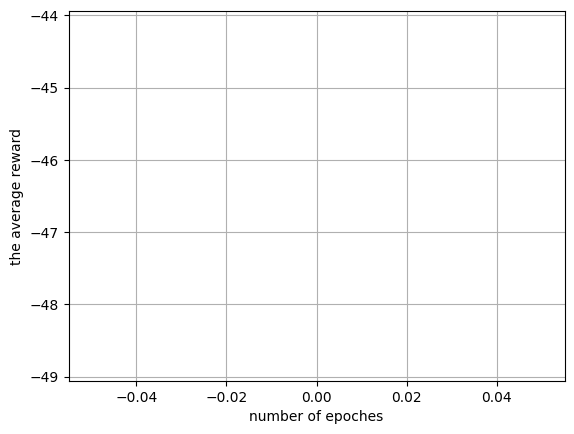

In [30]:
print(all_rewards)
#plt.plot(all_rewards)
#plt.xlabel('number of epoches')
#plt.ylabel('the average reward')
#plt.savefig("/media/l/data/HRC/HRC_intention_recognition/code/DD-Net-master/SHREC/images/RLsherc_14_reward_fine.png")
#plt.grid()

In [31]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 123.12it/s]


In [32]:

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/700
1960/1960 [==============================] - 4s 2ms/step - loss: 0.1431 - accuracy: 0.9714 - val_loss: 0.5340 - val_accuracy: 0.8702
Epoch 2/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.2920 - accuracy: 0.9291 - val_loss: 0.4885 - val_accuracy: 0.8810
Epoch 3/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.1791 - accuracy: 0.9638 - val_loss: 0.5654 - val_accuracy: 0.8667
Epoch 4/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.2131 - accuracy: 0.9459 - val_loss: 0.5249 - val_accuracy: 0.8893
Epoch 5/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.1987 - accuracy: 0.9520 - val_loss: 0.5032 - val_accuracy: 0.8845
Epoch 6/700
1960/1960 [==============================] - 0s 125us/step - loss: 0.1658 - accuracy: 0.9633 - val_loss: 0.4769 - val_accuracy: 0.8821
Epoch 7/700
1960/1960 [==============================] - 0s 116us/step - 

Epoch 57/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.0481 - accuracy: 0.9939 - val_loss: 0.3678 - val_accuracy: 0.9286
Epoch 58/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0457 - accuracy: 0.9949 - val_loss: 0.3668 - val_accuracy: 0.9286
Epoch 59/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.0465 - accuracy: 0.9959 - val_loss: 0.3657 - val_accuracy: 0.9298
Epoch 60/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0457 - accuracy: 0.9959 - val_loss: 0.3650 - val_accuracy: 0.9321
Epoch 61/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.0464 - accuracy: 0.9949 - val_loss: 0.3638 - val_accuracy: 0.9333
Epoch 62/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0450 - accuracy: 0.9959 - val_loss: 0.3628 - val_accuracy: 0.9333
Epoch 63/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.0443 - accuracy: 0.9959 - val_

Epoch 113/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0403 - accuracy: 0.9949 - val_loss: 0.3545 - val_accuracy: 0.9286
Epoch 114/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0425 - accuracy: 0.9969 - val_loss: 0.3545 - val_accuracy: 0.9286
Epoch 115/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0437 - accuracy: 0.9944 - val_loss: 0.3545 - val_accuracy: 0.9286
Epoch 116/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0377 - accuracy: 0.9974 - val_loss: 0.3545 - val_accuracy: 0.9286
Epoch 117/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0383 - accuracy: 0.9969 - val_loss: 0.3546 - val_accuracy: 0.9286
Epoch 118/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0398 - accuracy: 0.9980 - val_loss: 0.3546 - val_accuracy: 0.9286
Epoch 119/700
1960/1960 [==============================] - 0s 129us/step - loss: 0.0407 - accuracy: 0.9949

Epoch 168/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0434 - accuracy: 0.9934 - val_loss: 0.3578 - val_accuracy: 0.9286
Epoch 169/700
1960/1960 [==============================] - 0s 126us/step - loss: 0.0445 - accuracy: 0.9949 - val_loss: 0.3578 - val_accuracy: 0.9286
Epoch 170/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0412 - accuracy: 0.9959 - val_loss: 0.3577 - val_accuracy: 0.9286
Epoch 171/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0398 - accuracy: 0.9969 - val_loss: 0.3577 - val_accuracy: 0.9286
Epoch 172/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0364 - accuracy: 0.9974 - val_loss: 0.3577 - val_accuracy: 0.9286
Epoch 173/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0405 - accuracy: 0.9959 - val_loss: 0.3576 - val_accuracy: 0.9286
Epoch 174/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0382 - accuracy: 0.9974

Epoch 223/700
1960/1960 [==============================] - 0s 128us/step - loss: 0.0417 - accuracy: 0.9944 - val_loss: 0.3607 - val_accuracy: 0.9298
Epoch 224/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0433 - accuracy: 0.9934 - val_loss: 0.3608 - val_accuracy: 0.9298
Epoch 225/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0369 - accuracy: 0.9959 - val_loss: 0.3608 - val_accuracy: 0.9298
Epoch 226/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0415 - accuracy: 0.9959 - val_loss: 0.3609 - val_accuracy: 0.9298
Epoch 227/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0397 - accuracy: 0.9974 - val_loss: 0.3610 - val_accuracy: 0.9298
Epoch 228/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0383 - accuracy: 0.9969 - val_loss: 0.3611 - val_accuracy: 0.9298
Epoch 229/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0442 - accuracy: 0.9954

Epoch 278/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0399 - accuracy: 0.9964 - val_loss: 0.3628 - val_accuracy: 0.9298
Epoch 279/700
1960/1960 [==============================] - 0s 120us/step - loss: 0.0381 - accuracy: 0.9959 - val_loss: 0.3628 - val_accuracy: 0.9298
Epoch 280/700
1960/1960 [==============================] - 0s 125us/step - loss: 0.0393 - accuracy: 0.9974 - val_loss: 0.3628 - val_accuracy: 0.9298
Epoch 281/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0391 - accuracy: 0.9959 - val_loss: 0.3628 - val_accuracy: 0.9298
Epoch 282/700
1960/1960 [==============================] - 0s 126us/step - loss: 0.0444 - accuracy: 0.9954 - val_loss: 0.3628 - val_accuracy: 0.9298
Epoch 283/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0386 - accuracy: 0.9974 - val_loss: 0.3628 - val_accuracy: 0.9298
Epoch 284/700
1960/1960 [==============================] - 0s 122us/step - loss: 0.0403 - accuracy: 0.9964

Epoch 333/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0395 - accuracy: 0.9969 - val_loss: 0.3651 - val_accuracy: 0.9286
Epoch 334/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0383 - accuracy: 0.9964 - val_loss: 0.3652 - val_accuracy: 0.9286
Epoch 335/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0395 - accuracy: 0.9969 - val_loss: 0.3653 - val_accuracy: 0.9286
Epoch 336/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0385 - accuracy: 0.9974 - val_loss: 0.3654 - val_accuracy: 0.9274
Epoch 337/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0410 - accuracy: 0.9949 - val_loss: 0.3654 - val_accuracy: 0.9274
Epoch 338/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0402 - accuracy: 0.9949 - val_loss: 0.3654 - val_accuracy: 0.9274
Epoch 339/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0355 - accuracy: 0.9959

Epoch 388/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0436 - accuracy: 0.9929 - val_loss: 0.3645 - val_accuracy: 0.9262
Epoch 389/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0396 - accuracy: 0.9964 - val_loss: 0.3645 - val_accuracy: 0.9262
Epoch 390/700
1960/1960 [==============================] - 0s 125us/step - loss: 0.0350 - accuracy: 0.9964 - val_loss: 0.3646 - val_accuracy: 0.9262
Epoch 391/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0370 - accuracy: 0.9954 - val_loss: 0.3646 - val_accuracy: 0.9262
Epoch 392/700
1960/1960 [==============================] - 0s 125us/step - loss: 0.0447 - accuracy: 0.9929 - val_loss: 0.3646 - val_accuracy: 0.9262
Epoch 393/700
1960/1960 [==============================] - 0s 114us/step - loss: 0.0355 - accuracy: 0.9980 - val_loss: 0.3646 - val_accuracy: 0.9262
Epoch 394/700
1960/1960 [==============================] - 0s 122us/step - loss: 0.0405 - accuracy: 0.9969

Epoch 443/700
1960/1960 [==============================] - 0s 116us/step - loss: 0.0426 - accuracy: 0.9954 - val_loss: 0.3652 - val_accuracy: 0.9238
Epoch 444/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0377 - accuracy: 0.9969 - val_loss: 0.3652 - val_accuracy: 0.9238
Epoch 445/700
1960/1960 [==============================] - 0s 120us/step - loss: 0.0403 - accuracy: 0.9954 - val_loss: 0.3652 - val_accuracy: 0.9238
Epoch 446/700
1960/1960 [==============================] - 0s 123us/step - loss: 0.0381 - accuracy: 0.9969 - val_loss: 0.3653 - val_accuracy: 0.9238
Epoch 447/700
1960/1960 [==============================] - 0s 120us/step - loss: 0.0363 - accuracy: 0.9985 - val_loss: 0.3654 - val_accuracy: 0.9238
Epoch 448/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0397 - accuracy: 0.9974 - val_loss: 0.3655 - val_accuracy: 0.9238
Epoch 449/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0439 - accuracy: 0.9949

Epoch 498/700
1960/1960 [==============================] - 0s 125us/step - loss: 0.0399 - accuracy: 0.9954 - val_loss: 0.3678 - val_accuracy: 0.9262
Epoch 499/700
1960/1960 [==============================] - 0s 120us/step - loss: 0.0378 - accuracy: 0.9974 - val_loss: 0.3679 - val_accuracy: 0.9262
Epoch 500/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0398 - accuracy: 0.9954 - val_loss: 0.3680 - val_accuracy: 0.9262
Epoch 501/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0375 - accuracy: 0.9959 - val_loss: 0.3681 - val_accuracy: 0.9262
Epoch 502/700
1960/1960 [==============================] - 0s 123us/step - loss: 0.0351 - accuracy: 0.9985 - val_loss: 0.3682 - val_accuracy: 0.9262
Epoch 503/700
1960/1960 [==============================] - 0s 114us/step - loss: 0.0461 - accuracy: 0.9949 - val_loss: 0.3682 - val_accuracy: 0.9262
Epoch 504/700
1960/1960 [==============================] - 0s 123us/step - loss: 0.0410 - accuracy: 0.9954

Epoch 553/700
1960/1960 [==============================] - 0s 114us/step - loss: 0.0423 - accuracy: 0.9934 - val_loss: 0.3711 - val_accuracy: 0.9262
Epoch 554/700
1960/1960 [==============================] - 0s 123us/step - loss: 0.0371 - accuracy: 0.9974 - val_loss: 0.3710 - val_accuracy: 0.9262
Epoch 555/700
1960/1960 [==============================] - 0s 116us/step - loss: 0.0302 - accuracy: 0.9980 - val_loss: 0.3710 - val_accuracy: 0.9262
Epoch 556/700
1960/1960 [==============================] - 0s 126us/step - loss: 0.0354 - accuracy: 0.9969 - val_loss: 0.3710 - val_accuracy: 0.9250
Epoch 557/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0379 - accuracy: 0.9980 - val_loss: 0.3710 - val_accuracy: 0.9250
Epoch 558/700
1960/1960 [==============================] - 0s 124us/step - loss: 0.0371 - accuracy: 0.9974 - val_loss: 0.3710 - val_accuracy: 0.9250
Epoch 559/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.0358 - accuracy: 0.9990

Epoch 608/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0357 - accuracy: 0.9959 - val_loss: 0.3695 - val_accuracy: 0.9250
Epoch 609/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0372 - accuracy: 0.9980 - val_loss: 0.3695 - val_accuracy: 0.9250
Epoch 610/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0370 - accuracy: 0.9969 - val_loss: 0.3696 - val_accuracy: 0.9250
Epoch 611/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.0398 - accuracy: 0.9954 - val_loss: 0.3696 - val_accuracy: 0.9250
Epoch 612/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0371 - accuracy: 0.9974 - val_loss: 0.3697 - val_accuracy: 0.9250
Epoch 613/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.0430 - accuracy: 0.9954 - val_loss: 0.3697 - val_accuracy: 0.9250
Epoch 614/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0335 - accuracy: 0.9974

Epoch 663/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0386 - accuracy: 0.9969 - val_loss: 0.3716 - val_accuracy: 0.9250
Epoch 664/700
1960/1960 [==============================] - 0s 125us/step - loss: 0.0353 - accuracy: 0.9980 - val_loss: 0.3716 - val_accuracy: 0.9250
Epoch 665/700
1960/1960 [==============================] - 0s 118us/step - loss: 0.0355 - accuracy: 0.9969 - val_loss: 0.3716 - val_accuracy: 0.9250
Epoch 666/700
1960/1960 [==============================] - 0s 123us/step - loss: 0.0353 - accuracy: 0.9980 - val_loss: 0.3716 - val_accuracy: 0.9250
Epoch 667/700
1960/1960 [==============================] - 0s 119us/step - loss: 0.0391 - accuracy: 0.9964 - val_loss: 0.3717 - val_accuracy: 0.9250
Epoch 668/700
1960/1960 [==============================] - 0s 123us/step - loss: 0.0359 - accuracy: 0.9974 - val_loss: 0.3717 - val_accuracy: 0.9250
Epoch 669/700
1960/1960 [==============================] - 0s 117us/step - loss: 0.0359 - accuracy: 0.9974

In [33]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [34]:
labels_train = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels_train[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels_train[i])

In [ ]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

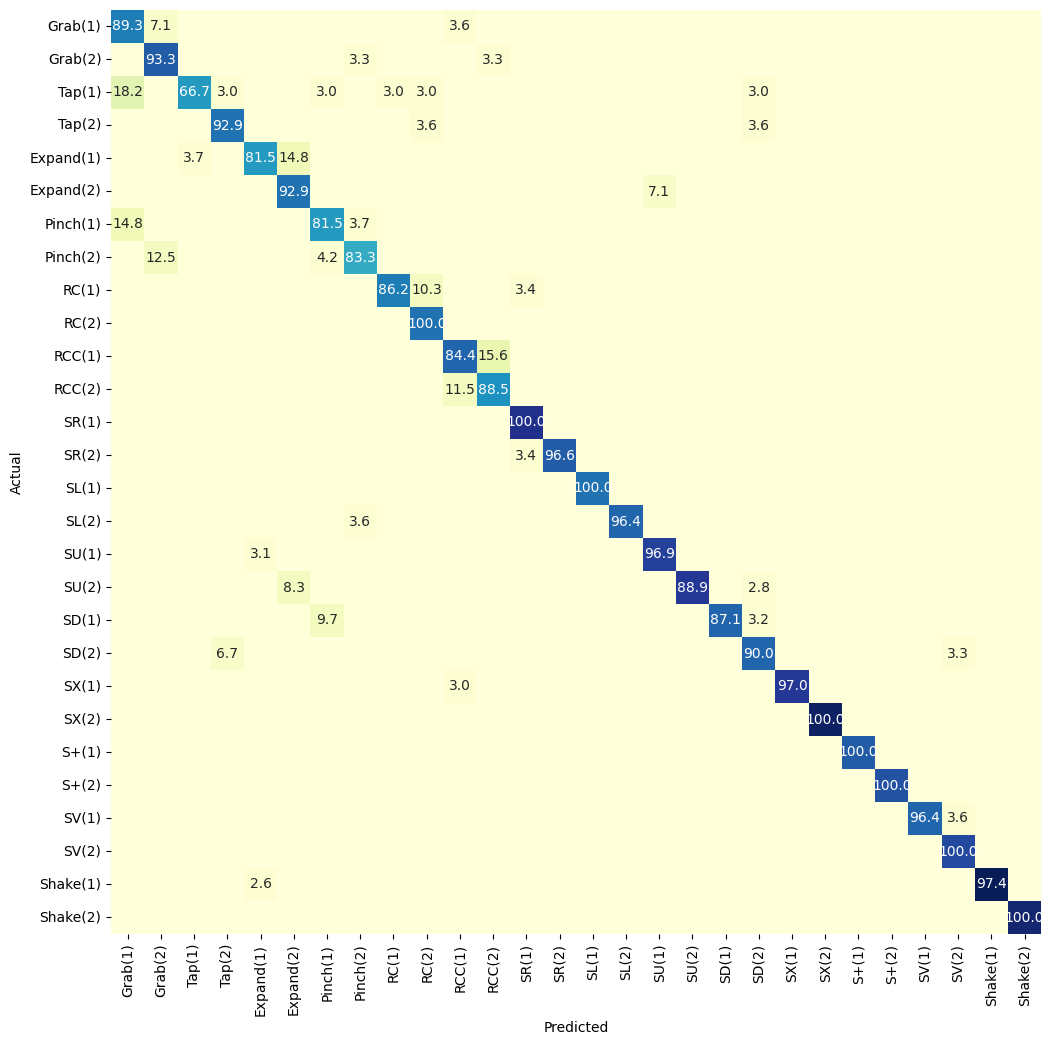

In [35]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_3.png', labels_train, ymap=None, figsize=(12,12))

### epoch 2 

In [ ]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

In [ ]:
print(all_rewards)

In [ ]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

In [ ]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_5.png', labels, ymap=None, figsize=(18,18))

### epoch 3

In [ ]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

### epoch 4

In [ ]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

### epoch 5

In [ ]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [ ]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

In [ ]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))